[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kdlamb/SP2-VAE/blob/main/SP2_2DLatentSpace.ipynb)

## SP2 2D Latent Space Analysis
This notebook uses the pyroVED library to analyze signals from the Single Particle Soot Photometer. Here we use a 2D latent space for the scattering and incandescent channels from the NOAA SP2.

## Download the L-II signal data
You can download the NOAA SP2 data directly from the [Zenodo repository](https://zenodo.org/records/15800436) by uncommenting and running the following code (can be slow). Alternatively, you can first download the data directly to your computer and then upload the files to Colab.

In [1]:
#!wget -O Lab_X_train.npy "https://zenodo.org/records/15800436/files/Lab_X_train.npy"
#!wget -O Lab_Y_train.npy "https://zenodo.org/records/15800436/files/Lab_Y_train.npy"
#!wget -O Lab_X_train.npy "https://zenodo.org/records/15800436/files/Lab_X_val.npy"
#!wget -O Lab_Y_train.npy "https://zenodo.org/records/15800436/files/Lab_Y_val.npy"
#!wget -O Lab_X_train.npy "https://zenodo.org/records/15800436/files/Lab_X_test.npy"
#!wget -O Lab_Y_train.npy "https://zenodo.org/records/15800436/files/Lab_Y_test.npy"

## Install packages and load in libraries

In [2]:
!pip install -q git+https://github.com/ziatdinovmax/pyroved.git

In [3]:
import os
import math
import numpy as np
import seaborn as sns
import pandas as pd
import time
import random

import torch

from torch.nn import Conv1d, ConvTranspose1d
from torch.nn import Linear as Lin, ReLU, Sigmoid, ConstantPad1d
from torch.utils.data import Dataset, DataLoader

import pyroved as pv

from matplotlib import pyplot as plt
from tqdm import tqdm

In [4]:
# for reproducibility
np.random.seed(0)
torch.manual_seed(0)

## Preprocess SP2 Data Sets

In [5]:
X_train = np.load("Lab_X_train.npy")
Y_train = np.load("Lab_Y_train.npy")

X_val = np.load("Lab_X_val.npy")
Y_val = np.load("Lab_Y_val.npy")

X_test = np.load("Lab_X_test.npy")
Y_test = np.load("Lab_Y_test.npy")

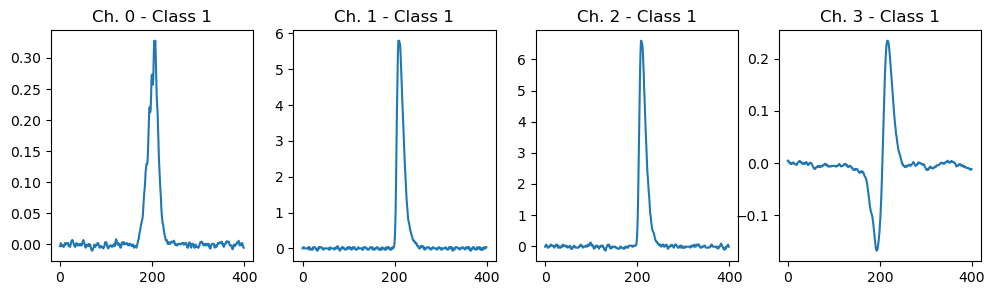

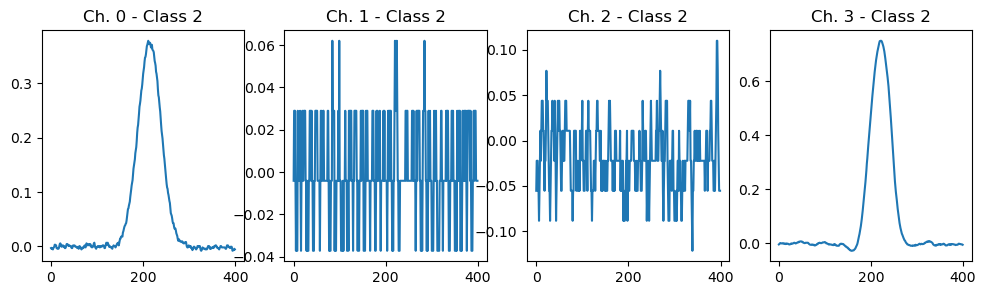

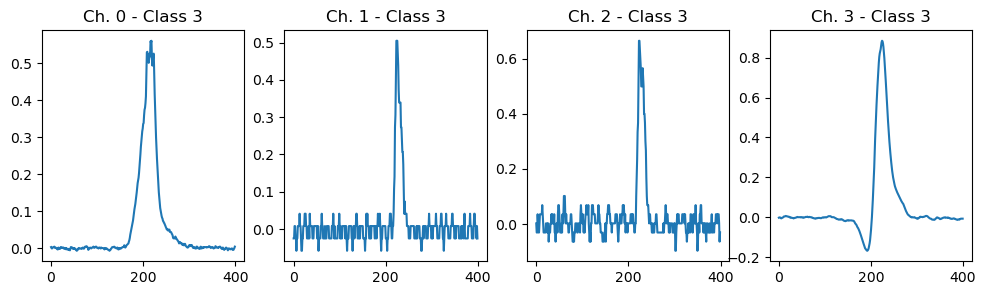

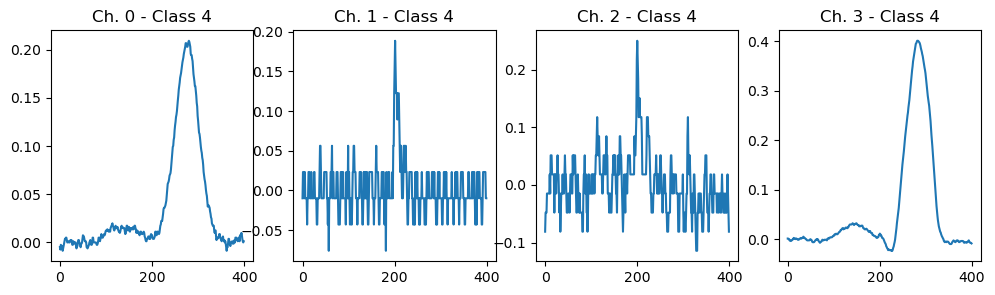

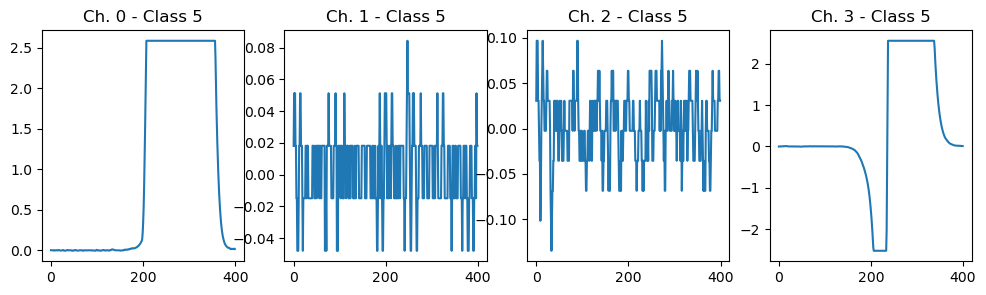

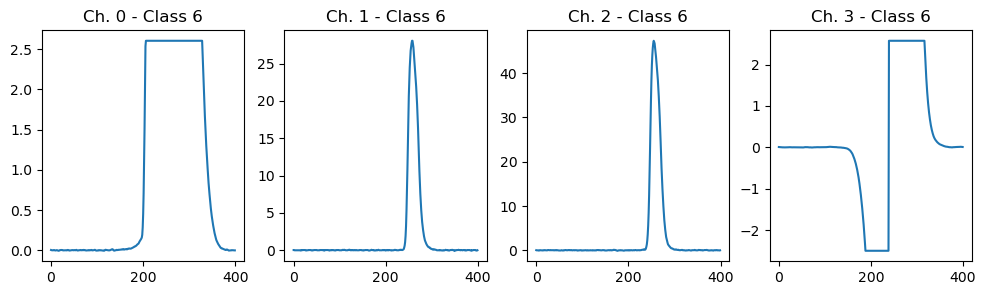

In [6]:
import random
import matplotlib.pyplot as plt

for class_label in range(1, 7):
    class_indices = [i for i, label in enumerate(Y_train) if label == class_label]

    random_index = random.choice(class_indices)

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
    axes[0].plot(X_train[random_index, :, 0])
    axes[0].set_title(f"Ch. 0 - Class {class_label}")
    # axes[0].set_xticks([])
    # axes[0].set_yticks([])
    axes[1].plot(X_train[random_index, :, 1])
    axes[1].set_title(f"Ch. 1 - Class {class_label}")
    # axes[1].set_xticks([])
    # axes[1].set_yticks([])
    axes[2].plot(X_train[random_index, :, 2])
    axes[2].set_title(f"Ch. 2 - Class {class_label}")
    # axes[2].set_xticks([])
    # axes[2].set_yticks([])
    axes[3].plot(X_train[random_index, :, 3])
    axes[3].set_title(f"Ch. 3 - Class {class_label}")
    # axes[3].set_xticks([])
    # axes[3].set_yticks([])

    plt.show()

[ 0.32379182 -0.0347452  -0.00413633 -0.47007435]
[ 0.23773234 -0.0223362  -0.02068167 -1.59423792]
[0.2894052  0.02316347 0.00165453 0.46486989]
[ 0.26431227 -0.01406353 -0.00661813 -2.52428748]
[ 0.26062577 -0.01075447  0.04880874 -2.51164808]


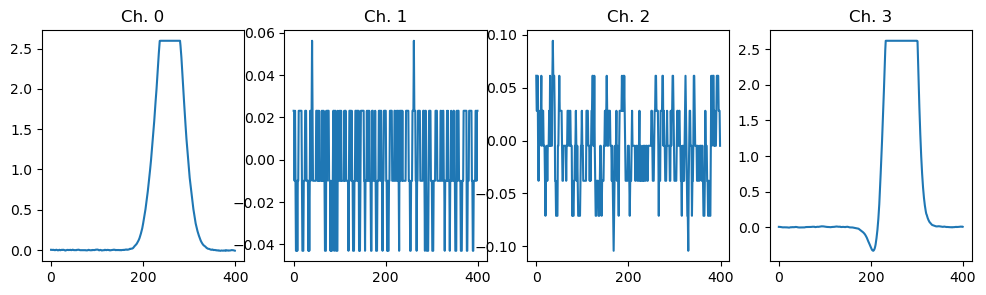

In [7]:
n = random.randint(1, 140081)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
axes[0].plot(X_train[n,:,0])
axes[0].set_title("Ch. 0")
axes[1].plot(X_train[n,:,1])
axes[1].set_title("Ch. 1")
axes[2].plot(X_train[n,:,2])
axes[2].set_title("Ch. 2")
axes[3].plot(X_train[n,:,3])
axes[3].set_title("Ch. 3")

random_indices = [random.randint(0, 140081) for _ in range(5)]

for idx in random_indices:
    print(X_train[idx, 199, :])

In [8]:
import numpy as np

unique_classes_orig, class_counts_orig = np.unique(Y_train, return_counts=True)

mask = np.any(X_train[:, :, 1] > 0.2, axis=1)
X_train_filtered = X_train[mask]
Y_train_filtered = Y_train[mask]

unique_classes_after, class_counts_after = np.unique(Y_train_filtered, return_counts=True)

print("Different aerosol classes detectable incandesence:")
for cls in unique_classes_orig:
    count_orig = class_counts_orig[unique_classes_orig == cls][0]
    count_after = class_counts_after[unique_classes_after == cls][0] if cls in unique_classes_after else 0
    percentage_change = (count_after / count_orig) * 100 if count_orig > 0 else 0
    print(f"Class {cls}: Before = {count_orig}, After = {count_after}, Percentage = {percentage_change:.2f}%")

Different aerosol classes detectable incandesence:
Class 0.0: Before = 20004, After = 19660, Percentage = 98.28%
Class 1.0: Before = 20018, After = 16223, Percentage = 81.04%
Class 2.0: Before = 20009, After = 1706, Percentage = 8.53%
Class 3.0: Before = 20001, After = 4786, Percentage = 23.93%
Class 4.0: Before = 20005, After = 5402, Percentage = 27.00%
Class 5.0: Before = 20008, After = 18377, Percentage = 91.85%
Class 6.0: Before = 20037, After = 19678, Percentage = 98.21%


In [9]:
# APPLY INCANDESCENT THRESHOLD
mask = np.any(X_train[:, :, 1] > 0.2, axis=1)
X_train = X_train[mask]
Y_train = Y_train[mask]

# APPLY INCANDESCENT THRESHOLD
mask_val = np.any(X_val[:, :, 1] > 0.2, axis=1)
X_val = X_val[mask_val]
Y_val = Y_val[mask_val]

# APPLY INCANDESCENT THRESHOLD
mask_test = np.any(X_test[:, :, 1] > 0.2, axis=1)
X_test = X_test[mask_test]
Y_test = Y_test[mask_test]

In [10]:
def get_features(Xdata):
  # proprocess data from the SP2
  # get typical features used in analysis (color ratio, peak heights)
  # normalize data for each channel

  X_min = np.min(Xdata,axis=1)
  X_max = np.max(Xdata,axis=1)
  # Calculate the color ratio
  color_ratio = X_max[:,1] / X_max[:,2]

  X_norm = (Xdata-np.repeat(X_min[:,np.newaxis,:],400,axis=1))
  X_norm/=(np.repeat(X_max[:,np.newaxis,:],400,axis=1)-np.repeat(X_min[:,np.newaxis,:],400,axis=1))

  return X_norm,color_ratio,X_min,X_max

In [11]:
X_train,color_channel_ratio,channel_min_X_train,channel_max_X_train = get_features(X_train)
X_val,color_channel_ratio_val,channel_min_X_val,channel_max_X_val = get_features(X_val)
X_test,color_channel_ratio_test,channel_min_test,channel_max_X_test = get_features(X_test)

Text(0.5, 1.0, 'Ch. 3')

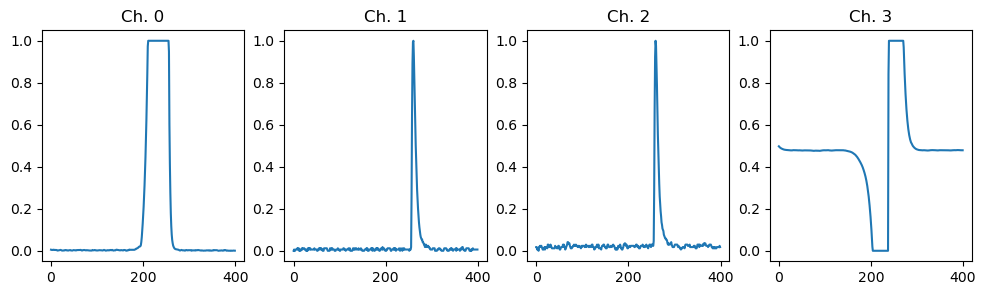

In [12]:
n = random.randint(1, X_train.shape[0])
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
axes[0].plot(X_train[n,:,0])
axes[0].set_title("Ch. 0")
axes[1].plot(X_train[n,:,1])
axes[1].set_title("Ch. 1")
axes[2].plot(X_train[n,:,2])
axes[2].set_title("Ch. 2")
axes[3].plot(X_train[n,:,3])
axes[3].set_title("Ch. 3")


## Train VAE models on Ch. 0 and Ch. 1

In [13]:
X_train_C0 = torch.from_numpy(X_train[:,:, 0]).float()
train_loader_0 = pv.utils.init_dataloader(X_train_C0.unsqueeze(1), batch_size=64)

X_train_C1 = torch.from_numpy(X_train[:,:, 1]).float()
train_loader_1 = pv.utils.init_dataloader(X_train_C1.unsqueeze(1), batch_size=64)

X_val_C0 = torch.from_numpy(X_val[:,:, 0]).float()
val_loader_0 = pv.utils.init_dataloader(X_val_C0.unsqueeze(1), batch_size=64)

X_val_C1 = torch.from_numpy(X_val[:,:, 1]).float()
val_loader_1 = pv.utils.init_dataloader(X_val_C1.unsqueeze(1), batch_size=64)

X_test_C0 = torch.from_numpy(X_test[:,:, 0]).float()
test_loader_0 = pv.utils.init_dataloader(X_test_C0.unsqueeze(1), batch_size=64)

X_test_C1 = torch.from_numpy(X_test[:,:, 1]).float()
test_loader_1 = pv.utils.init_dataloader(X_test_C1.unsqueeze(1), batch_size=64)

In [14]:
# Initialize vanilla VAE
vae0 = pv.models.iVAE(data_dim = (400,), latent_dim = 2, invariances=None, sampler_d = 'gaussian', seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae0)

In [25]:
 # Train for n epochs:
 for e in range(200):
     trainer.step(train_loader_0)
     trainer.print_statistics()
 torch.save(vae0.state_dict(), "2DVAE_Ch0_200.pth")

Epoch: 1 Training loss: 104.5246
Epoch: 2 Training loss: 100.5075
Epoch: 3 Training loss: 100.0803
Epoch: 4 Training loss: 99.7511
Epoch: 5 Training loss: 99.5289
Epoch: 6 Training loss: 99.4177
Epoch: 7 Training loss: 99.2737
Epoch: 8 Training loss: 99.1897
Epoch: 9 Training loss: 99.0986
Epoch: 10 Training loss: 99.0267
Epoch: 11 Training loss: 98.9884
Epoch: 12 Training loss: 98.9226
Epoch: 13 Training loss: 98.8771
Epoch: 14 Training loss: 98.8774
Epoch: 15 Training loss: 98.8119
Epoch: 16 Training loss: 98.7980
Epoch: 17 Training loss: 98.7832
Epoch: 18 Training loss: 98.7586
Epoch: 19 Training loss: 98.7538
Epoch: 20 Training loss: 98.7119
Epoch: 21 Training loss: 98.7180
Epoch: 22 Training loss: 98.6850
Epoch: 23 Training loss: 98.6828
Epoch: 24 Training loss: 98.6496
Epoch: 25 Training loss: 98.6055
Epoch: 26 Training loss: 98.6075
Epoch: 27 Training loss: 98.6335
Epoch: 28 Training loss: 98.6606
Epoch: 29 Training loss: 98.6002
Epoch: 30 Training loss: 98.5947
Epoch: 31 Traini

In [15]:
# Load in the trained model weights
vae0.load_state_dict(torch.load('2DVAE_Ch0_200.pth',weights_only=True))

<All keys matched successfully>

In [16]:
vae1 = pv.models.iVAE(data_dim = (400,), latent_dim = 2, invariances=None, sampler_d = 'gaussian', seed=0)

# Initialize SVI trainer
trainer1 = pv.trainers.SVItrainer(vae1)

In [28]:
# Train for n epochs:
for e in range(200):
    trainer1.step(train_loader_1)
    trainer1.print_statistics()
torch.save(vae1.state_dict(), "2DVAE_Ch1_200.pth")

Epoch: 1 Training loss: 102.0565
Epoch: 2 Training loss: 97.4187
Epoch: 3 Training loss: 96.9686
Epoch: 4 Training loss: 96.7589
Epoch: 5 Training loss: 96.6281
Epoch: 6 Training loss: 96.5443
Epoch: 7 Training loss: 96.4874
Epoch: 8 Training loss: 96.4373
Epoch: 9 Training loss: 96.4077
Epoch: 10 Training loss: 96.3739
Epoch: 11 Training loss: 96.3489
Epoch: 12 Training loss: 96.3199
Epoch: 13 Training loss: 96.3078
Epoch: 14 Training loss: 96.2916
Epoch: 15 Training loss: 96.2734
Epoch: 16 Training loss: 96.2664
Epoch: 17 Training loss: 96.2613
Epoch: 18 Training loss: 96.2433
Epoch: 19 Training loss: 96.2303
Epoch: 20 Training loss: 96.2080
Epoch: 21 Training loss: 96.2035
Epoch: 22 Training loss: 96.1975
Epoch: 23 Training loss: 96.1887
Epoch: 24 Training loss: 96.1726
Epoch: 25 Training loss: 96.1759
Epoch: 26 Training loss: 96.1604
Epoch: 27 Training loss: 96.1567
Epoch: 28 Training loss: 96.1476
Epoch: 29 Training loss: 96.1460
Epoch: 30 Training loss: 96.1342
Epoch: 31 Training

In [17]:
# Load in the trained model weights
vae1.load_state_dict(torch.load('2DVAE_Ch1_200.pth',weights_only=True))

<All keys matched successfully>

## Analyze the latent manifolds for Ch. 0 and Ch. 1

In [19]:
from typing import Optional, Tuple, Union, List
from torchvision.utils import make_grid
import pyro.distributions as dist
tt = torch.tensor

from pyroved.utils import (
    generate_grid, generate_latent_grid, get_sampler,
    plot_img_grid, plot_spect_grid, set_deterministic_mode,
    to_onehot, transform_coordinates)

def generate_latent_grid(d: int, **kwargs) -> torch.Tensor:
    """
    Generates a grid of latent space coordinates
    """
    if isinstance(d, int):
        d = [d, d]
    z_coord = kwargs.get("z_coord")
    if z_coord:
        z1, z2, z3, z4 = z_coord
        grid_x = torch.linspace(z2, z1, d[0])
        grid_y = torch.linspace(z3, z4, d[1])
    else:
        grid_x = dist.Normal(0, 1).icdf(torch.linspace(0.95, 0.05, d[0]))
        grid_y = dist.Normal(0, 1).icdf(torch.linspace(0.05, 0.95, d[1]))
    z = []
    for xi in grid_x:
        for yi in grid_y:
            z.append(tt([xi, yi]).float().unsqueeze(0))
    return torch.cat(z), (grid_x, grid_y)

def manifold2d(model, d: int, y: torch.Tensor = None,plot: bool = True,**kwargs: Union[str, int, float]) -> torch.Tensor:

    # kwargs = {}
    # kwargs["z_coord"]=(-2,2,-2,2)
    # kwargs.get("z_coord")

    z, (grid_x, grid_y) = generate_latent_grid(d, **kwargs)
    z = [z]

    loc = model.decode(*z, **kwargs)

    return loc, grid_x,grid_y
def plot_spect_grid(spectra: torch.Tensor, d: int, labels: List[str],
                    xticks: List[float], yticks: List[float], figtitle=str,plotname=str):
    """
    Plots a *d*-by-*d* square grid with 1D spectral plots
    """
    fig, axes = plt.subplots(d, d, figsize=(8, 8),
                           subplot_kw={'xticks': [], 'yticks': []},
                           gridspec_kw=dict(hspace=0.1, wspace=0.1))

    spectra = spectra.cpu()
    for ax, y in zip(axes.flat, spectra):
        ax.plot(y.squeeze())
    fs = 20
  # Add centered global x and y labels
    fig.text(0.5, 0.04, labels[0], ha='center', va='center', fontsize=fs)  # bottom center
    fig.text(0.04, 0.5, labels[1], ha='center', va='center', rotation='vertical', fontsize=fs)  # left center
    fig.suptitle(figtitle, fontsize=fs+2,y=0.93)
    # Add an invisible global axis for ticks
    ax_big = fig.add_subplot(111, frameon=False)
    ax_big.tick_params(labelcolor='black', top=False, bottom=True,
                       left=True, right=False, labelsize=16)
    ax_big.set_xticks(np.linspace(0.05,0.95,num=d))
    ax_big.set_yticks(np.linspace(0.05,0.95,num=d))
    ax_big.set_xticklabels([f"{x:.2f}" for x in xticks])
    ax_big.set_yticklabels([f"{y:.2f}" for y in yticks])

    # Hide the actual frame
    ax_big.spines[:].set_visible(False)

    plt.savefig(plotname,dpi=300)

In [20]:
manifold0,xvals0,yvals0=manifold2d(vae0,d=10)
manifold1,xvals1,yvals1=manifold2d(vae1,d=10)

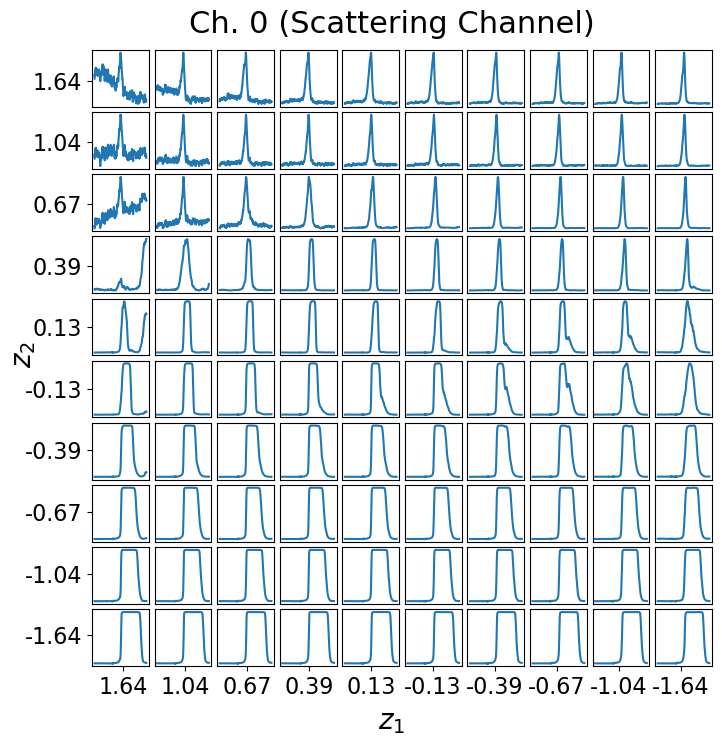

In [21]:
# Manifold Channel 0 (Scattering Channel)
plot_spect_grid(manifold0, d=10,labels=["$z_1$","$z_2$"],xticks=xvals0,yticks=yvals0,
                figtitle="Ch. 0 (Scattering Channel)",plotname="ManifoldCh0.png")

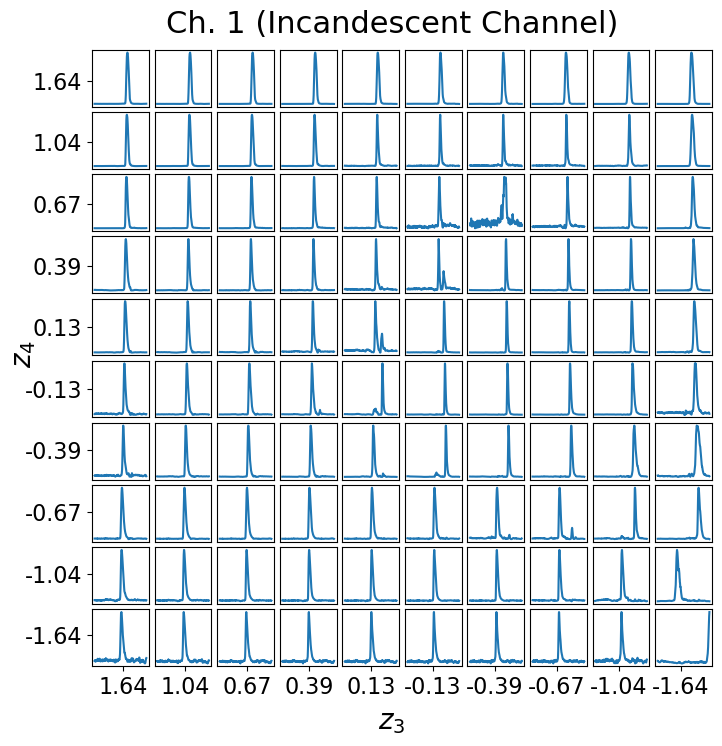

In [22]:
# Manifold Channel 1 (Incandescent Channel)
plot_spect_grid(manifold1, d=10,labels=["$z_3$","$z_4$"],xticks=xvals1,yticks=yvals1,
                figtitle="Ch. 1 (Incandescent Channel)",plotname="ManifoldCh1.png")

In [23]:
from scipy.signal import chirp, find_peaks, peak_widths
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

In [24]:
def skewnorm_pdf(x, a, loc, scale):
    return skewnorm.pdf(x, a, loc, scale)
def get_peak_info(signals):
    n = signals.shape[0]
    fwhm = np.zeros(n)
    peakloc = np.zeros(n)
    startloc = np.zeros(n)
    skewness = np.zeros(n)

    for i in range(0,signals.shape[0]):
        x = signals[i,:]
        peaks, peak_properties = find_peaks(x, height=(None, 1))
        maxpeak = np.argmax(peak_properties['peak_heights'])
        peakloc[i]=peaks[maxpeak]

        results_half = peak_widths(x, peaks, rel_height=0.5)
        fwhm[i]=results_half[0][maxpeak]
        startloc[i]=results_half[2][maxpeak]-results_half[0][maxpeak]

        try:
            popt, _ = curve_fit(skewnorm_pdf, np.arange(0,400), x, p0=[5,200,20], maxfev=200)
            a_fit, loc_fit, scale_fit = popt
        except:
            a_fit = np.nan
        skewness[i] = a_fit

    return peakloc,startloc,fwhm, skewness

In [25]:
peaklocsCh0,startlocsCh0,fwhmCh0,skewnessCh0 = get_peak_info(manifold0)
peaklocsCh1,startlocsCh1,fwhmCh1,skewnessCh1 = get_peak_info(manifold1)

In [26]:
xvals0.numpy()

array([ 1.6448534 ,  1.0364336 ,  0.67448974,  0.3853204 ,  0.12566137,
       -0.12566137, -0.38532048, -0.67448974, -1.0364336 , -1.6448534 ],
      dtype=float32)

(2, 3)


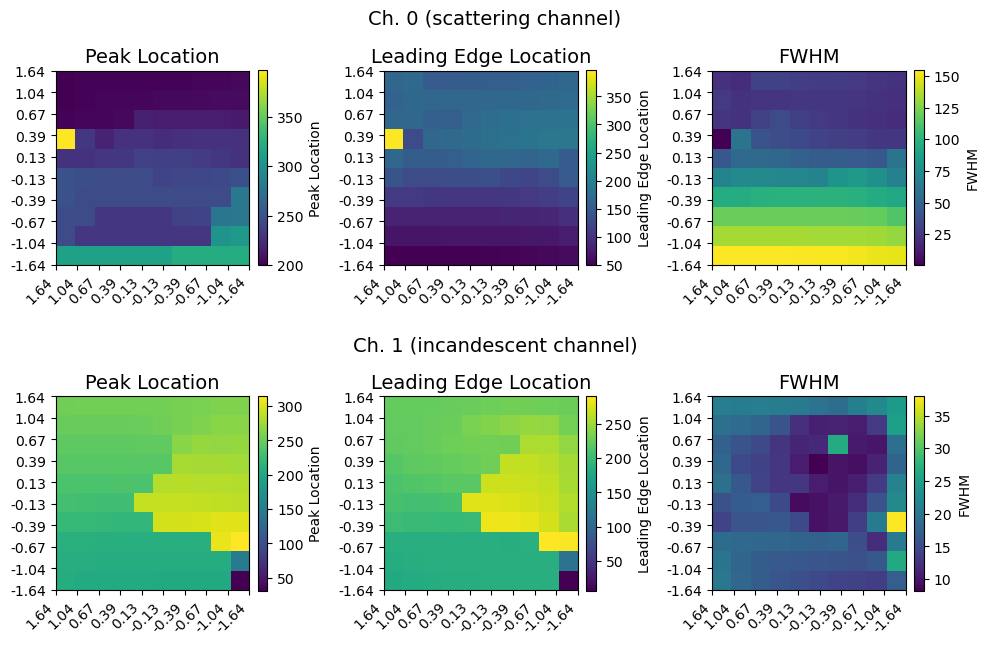

In [27]:
data = [
    ("Peak Location", peaklocsCh0.reshape(10, 10)),
    ("Leading Edge Location", startlocsCh0.reshape(10, 10)),
    ("FWHM", fwhmCh0.reshape(10, 10)),
    #("Skewness", skewnessCh0.reshape(10, 10))
]
xticks = xvals0.numpy()
yticks = yvals0.numpy()

x_tick_locations = np.linspace(-0.5,9.5,num=10) 
x_tick_labels = [f"{x:.2f}" for x in xticks]
y_tick_locations = np.linspace(-0.5,9.5,num=10) 
y_tick_labels = [f"{y:.2f}" for y in yticks[::-1]]

fig, axes = plt.subplots(2,3, figsize=(10, 7))

print(axes.shape)
ax0 = axes[0,:]
fig.suptitle("Ch. 0 (scattering channel)", fontsize=14,y=0.95)
for ax0, (title, img) in zip(ax0.flat, data):
    im = ax0.imshow(img, cmap='viridis')
    ax0.set_title(title, fontsize=14)
    cbar = fig.colorbar(im, ax=ax0, fraction=0.046, pad=0.04)
    cbar.set_label(title)
    cbar.ax.tick_params(labelsize=10)

ax1 = axes[1,:]

data = [
    ("Peak Location", peaklocsCh1.reshape(10, 10)),
    ("Leading Edge Location", startlocsCh1.reshape(10, 10)),
    ("FWHM", fwhmCh1.reshape(10, 10)),
    #("Skewness", skewnessCh0.reshape(10, 10))
]

# Add text in figure coordinates
plt.figtext(0.5, 0.47, "Ch. 1 (incandescent channel)", ha='center', va='center',fontsize=14)
# ax.suptitle(, fontsize=14,y=0.9)
#plt.subplots_adjust(hspace=-0.3)
for ax1, (title, img) in zip(ax1.flat, data):
    im = ax1.imshow(img, cmap='viridis')
    ax1.set_title(title, fontsize=14)
    cbar = fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    cbar.set_label(title)
    cbar.ax.tick_params(labelsize=10)

for ax in axes.flat:
    ax.set_xticks(x_tick_locations)
    ax.set_xticklabels(x_tick_labels, rotation=45, ha='right') # Rotate labels for better readability
    # Set y-axis ticks and labels
    ax.set_yticks(y_tick_locations)
    ax.set_yticklabels(y_tick_labels)

plt.tight_layout()

plt.savefig("ManifoldAnalysis.png",dpi=300)

## Compare latent variables in incandescent max. vs. color ratio space

In [28]:
# Encode each sample as latent variables
z_mean_0, z_sd_0 = vae0.encode(X_train_C0)
z_mean_1, z_sd_1 = vae1.encode(X_train_C1)

zval_mean_0, zval_sd_0 = vae0.encode(X_val_C0)
zval_mean_1, zval_sd_1 = vae1.encode(X_val_C1)

ztest_mean_0, ztest_sd_0 = vae0.encode(X_test_C0)
ztest_mean_1, ztest_sd_1 = vae1.encode(X_test_C1)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.colors import ListedColormap

target_names = ["FS", "FS+glyc", "CFA", "ATD", "VA", "$Fe_{2}O_{3}$", "$Fe_{3}O_{4}$"]
cmap1 = ListedColormap(['red', 'purple', 'orange', 'gray', 'brown', 'blue', 'green'])

/var/folders/n1/j9r40q610fjg5jmq47vnbz2m0000gn/T/ipykernel_10827/3274968094.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(target_names,fontsize=fs)


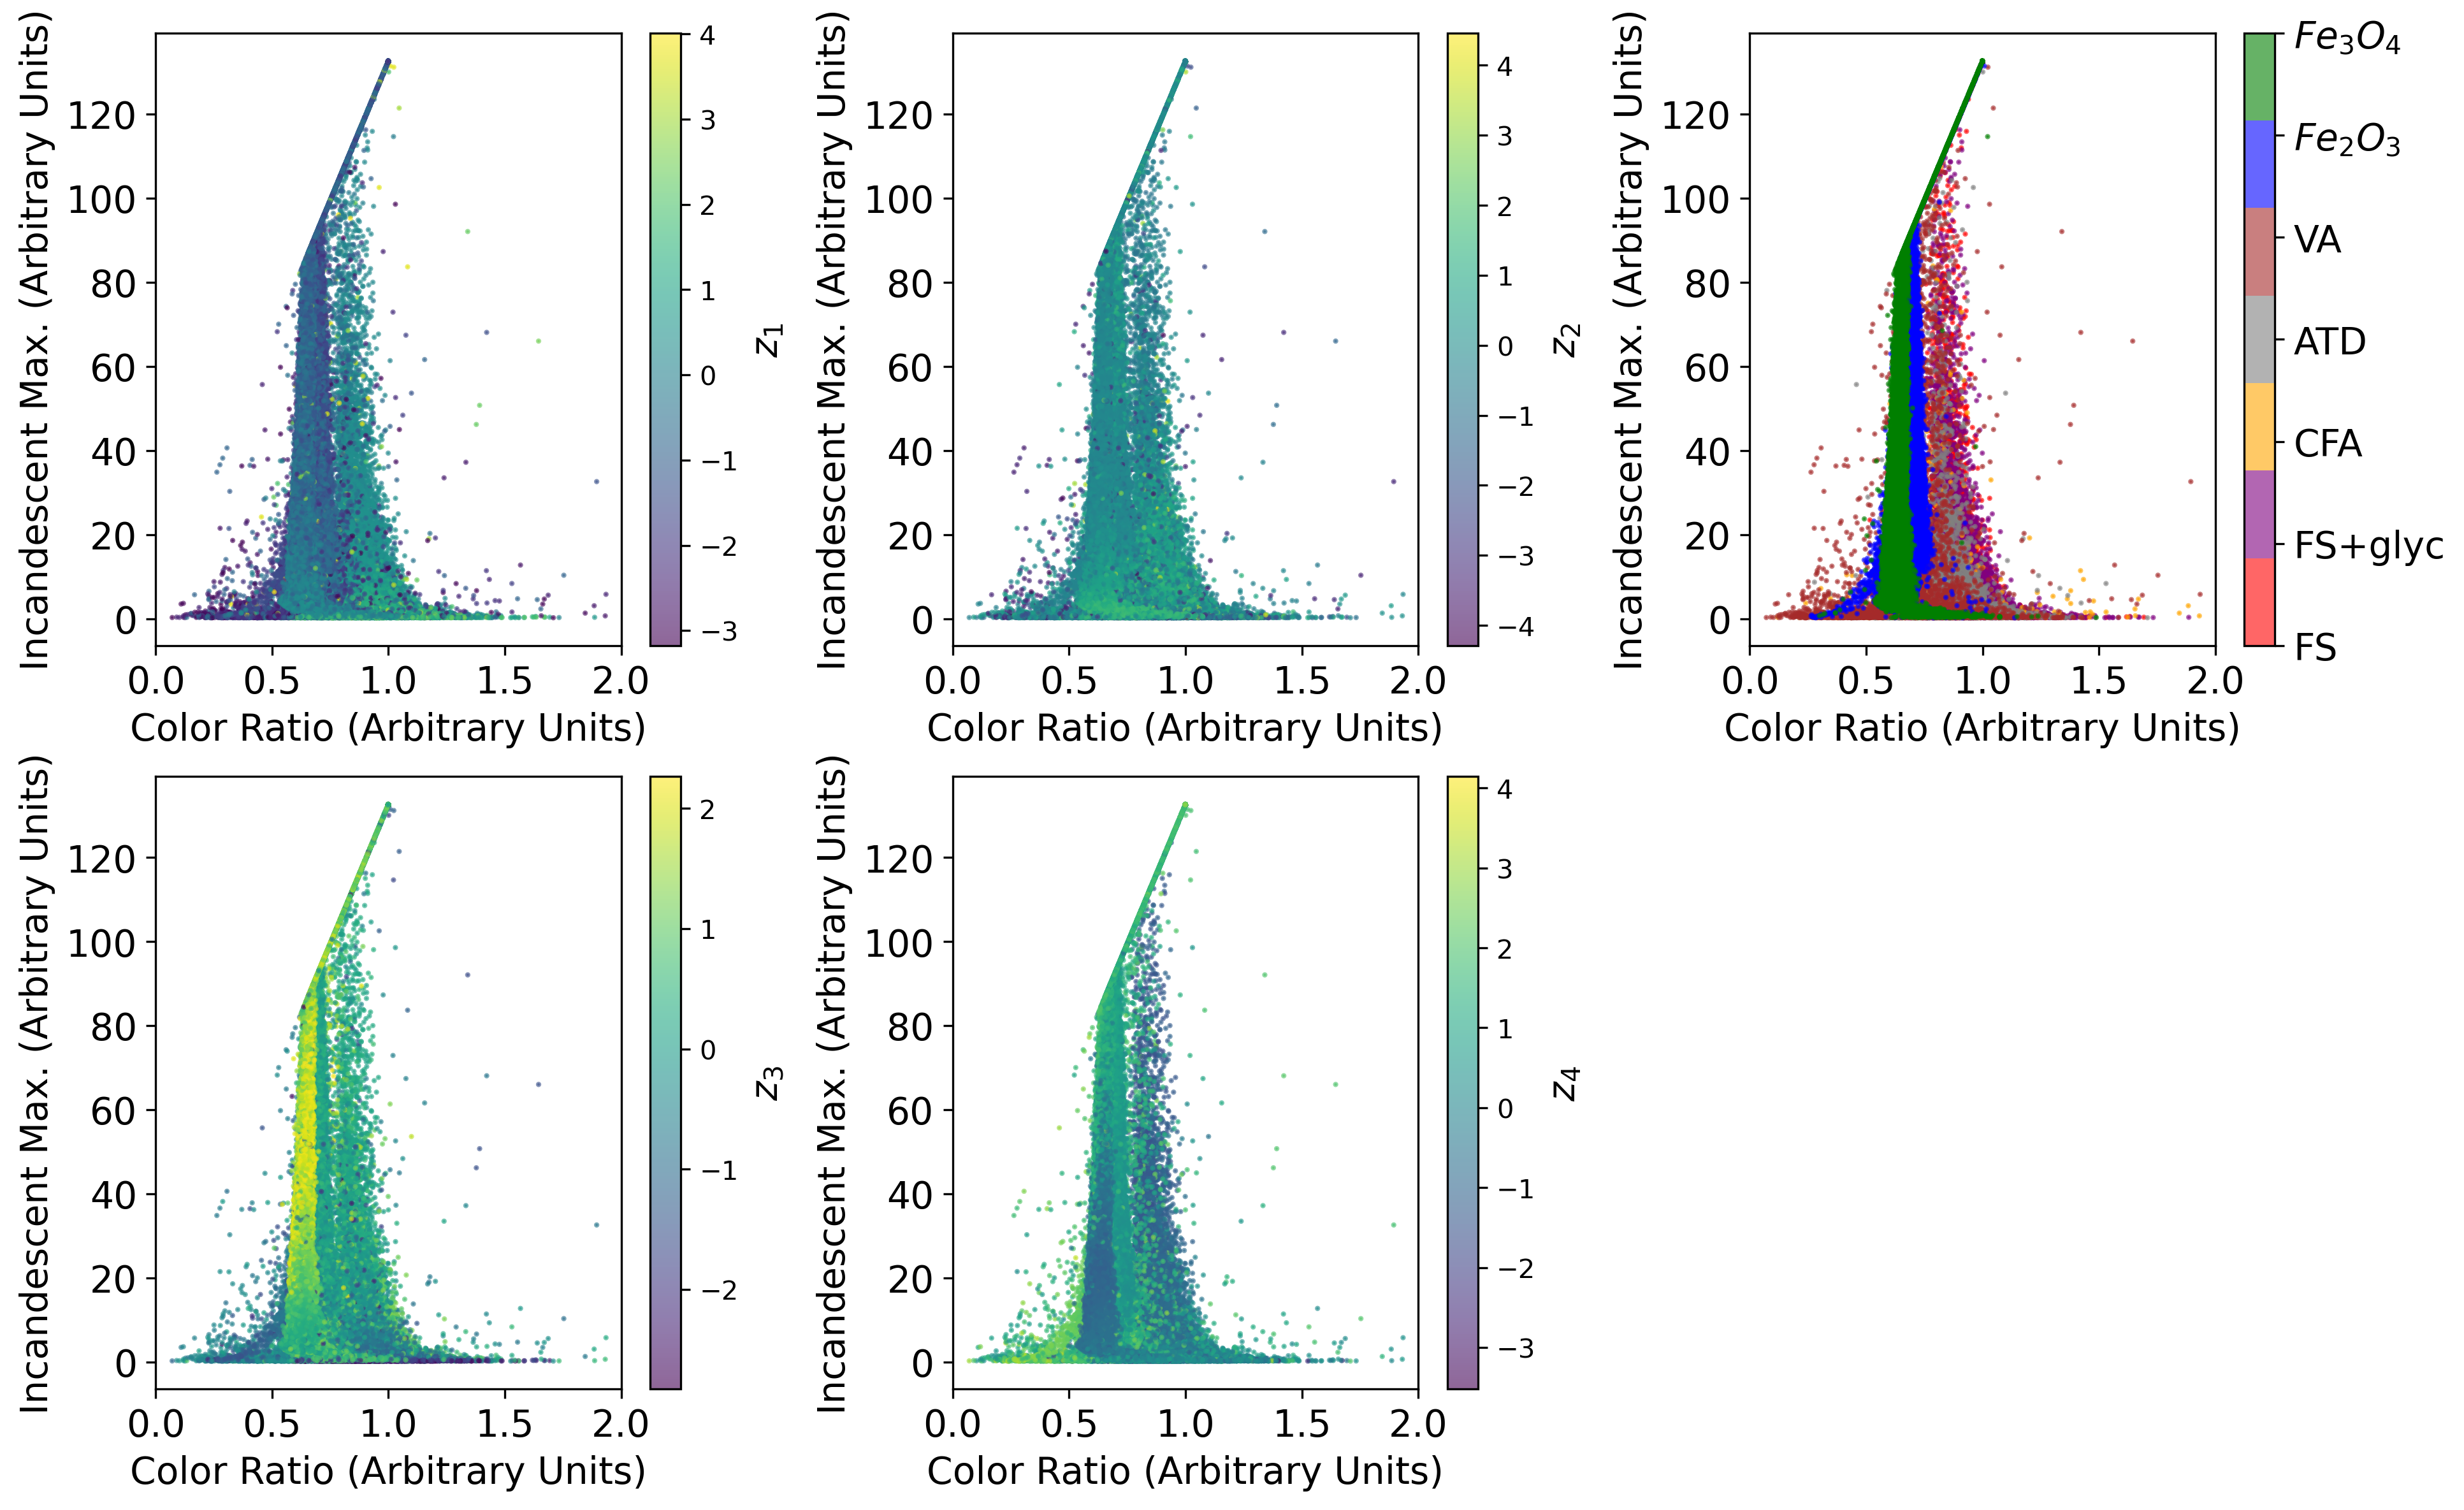

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,3, figsize=(13, 8), dpi=300)
fig.subplots_adjust(hspace=0.3, wspace=0.3)

z_data = [z_mean_0[:,0], z_mean_0[:,1], z_mean_1[:,0], z_mean_1[:,1]]
z_labels = ['$z_1$', '$z_2$', '$z_3$', '$z_4$']

axes = axes.flatten()

for ax in axes:
    ax.tick_params(labelsize=14)

fs = 14
for i in range(2):
    sc = axes[i].scatter(
        color_channel_ratio,
        channel_max_X_train[:,1],
        c=z_data[i],
        s=1,
        cmap='viridis',
        alpha=0.6
    )
    axes[i].set_xlim(0, 2)
    axes[i].set_xlabel("Color Ratio (Arbitrary Units)",fontsize=fs)
    axes[i].set_ylabel("Incandescent Max. (Arbitrary Units)",fontsize=fs)
    cbar = fig.colorbar(sc, ax=axes[i])
    cbar.set_label(z_labels[i],fontsize=fs)
    # axes[i].set_title(f"Scatter Plot Colored by {z_labels[i]}")


sc = axes[2].scatter(
    color_channel_ratio,
    channel_max_X_train[:,1],
    c=Y_train_filtered,
    s=1,
    cmap=cmap1,
    alpha=0.6
)
axes[2].set_xlim(0, 2)
axes[2].set_xlabel("Color Ratio (Arbitrary Units)",fontsize=fs)
axes[2].set_ylabel("Incandescent Max. (Arbitrary Units)",fontsize=fs)
cbar = fig.colorbar(sc, ax=axes[2])
cbar.set_ticklabels(target_names,fontsize=fs)

for i in range(2):
    sc = axes[3+i].scatter(
        color_channel_ratio,
        channel_max_X_train[:,1],
        c=z_data[2+i],
        s=1,
        cmap='viridis',
        alpha=0.6
    )
    axes[3+i].set_xlim(0, 2)
    axes[3+i].set_xlabel("Color Ratio (Arbitrary Units)",fontsize=fs)
    axes[3+i].set_ylabel("Incandescent Max. (Arbitrary Units)",fontsize=fs)
    cbar = fig.colorbar(sc, ax=axes[3+i])
    cbar.set_label(z_labels[2+i],fontsize=fs)
    # axes[i].set_title(f"Scatter Plot Colored by {z_labels[i]}")

axes[5].remove()

plt.tight_layout()
plt.savefig("color_ratio_z1_to_z4.png", dpi=300)
plt.show()


## Latent Space Visualization by Aerosol Class


0 (19660,)
1 (16223,)
2 (1706,)
3 (4786,)
4 (5402,)
5 (18377,)
6 (19678,)


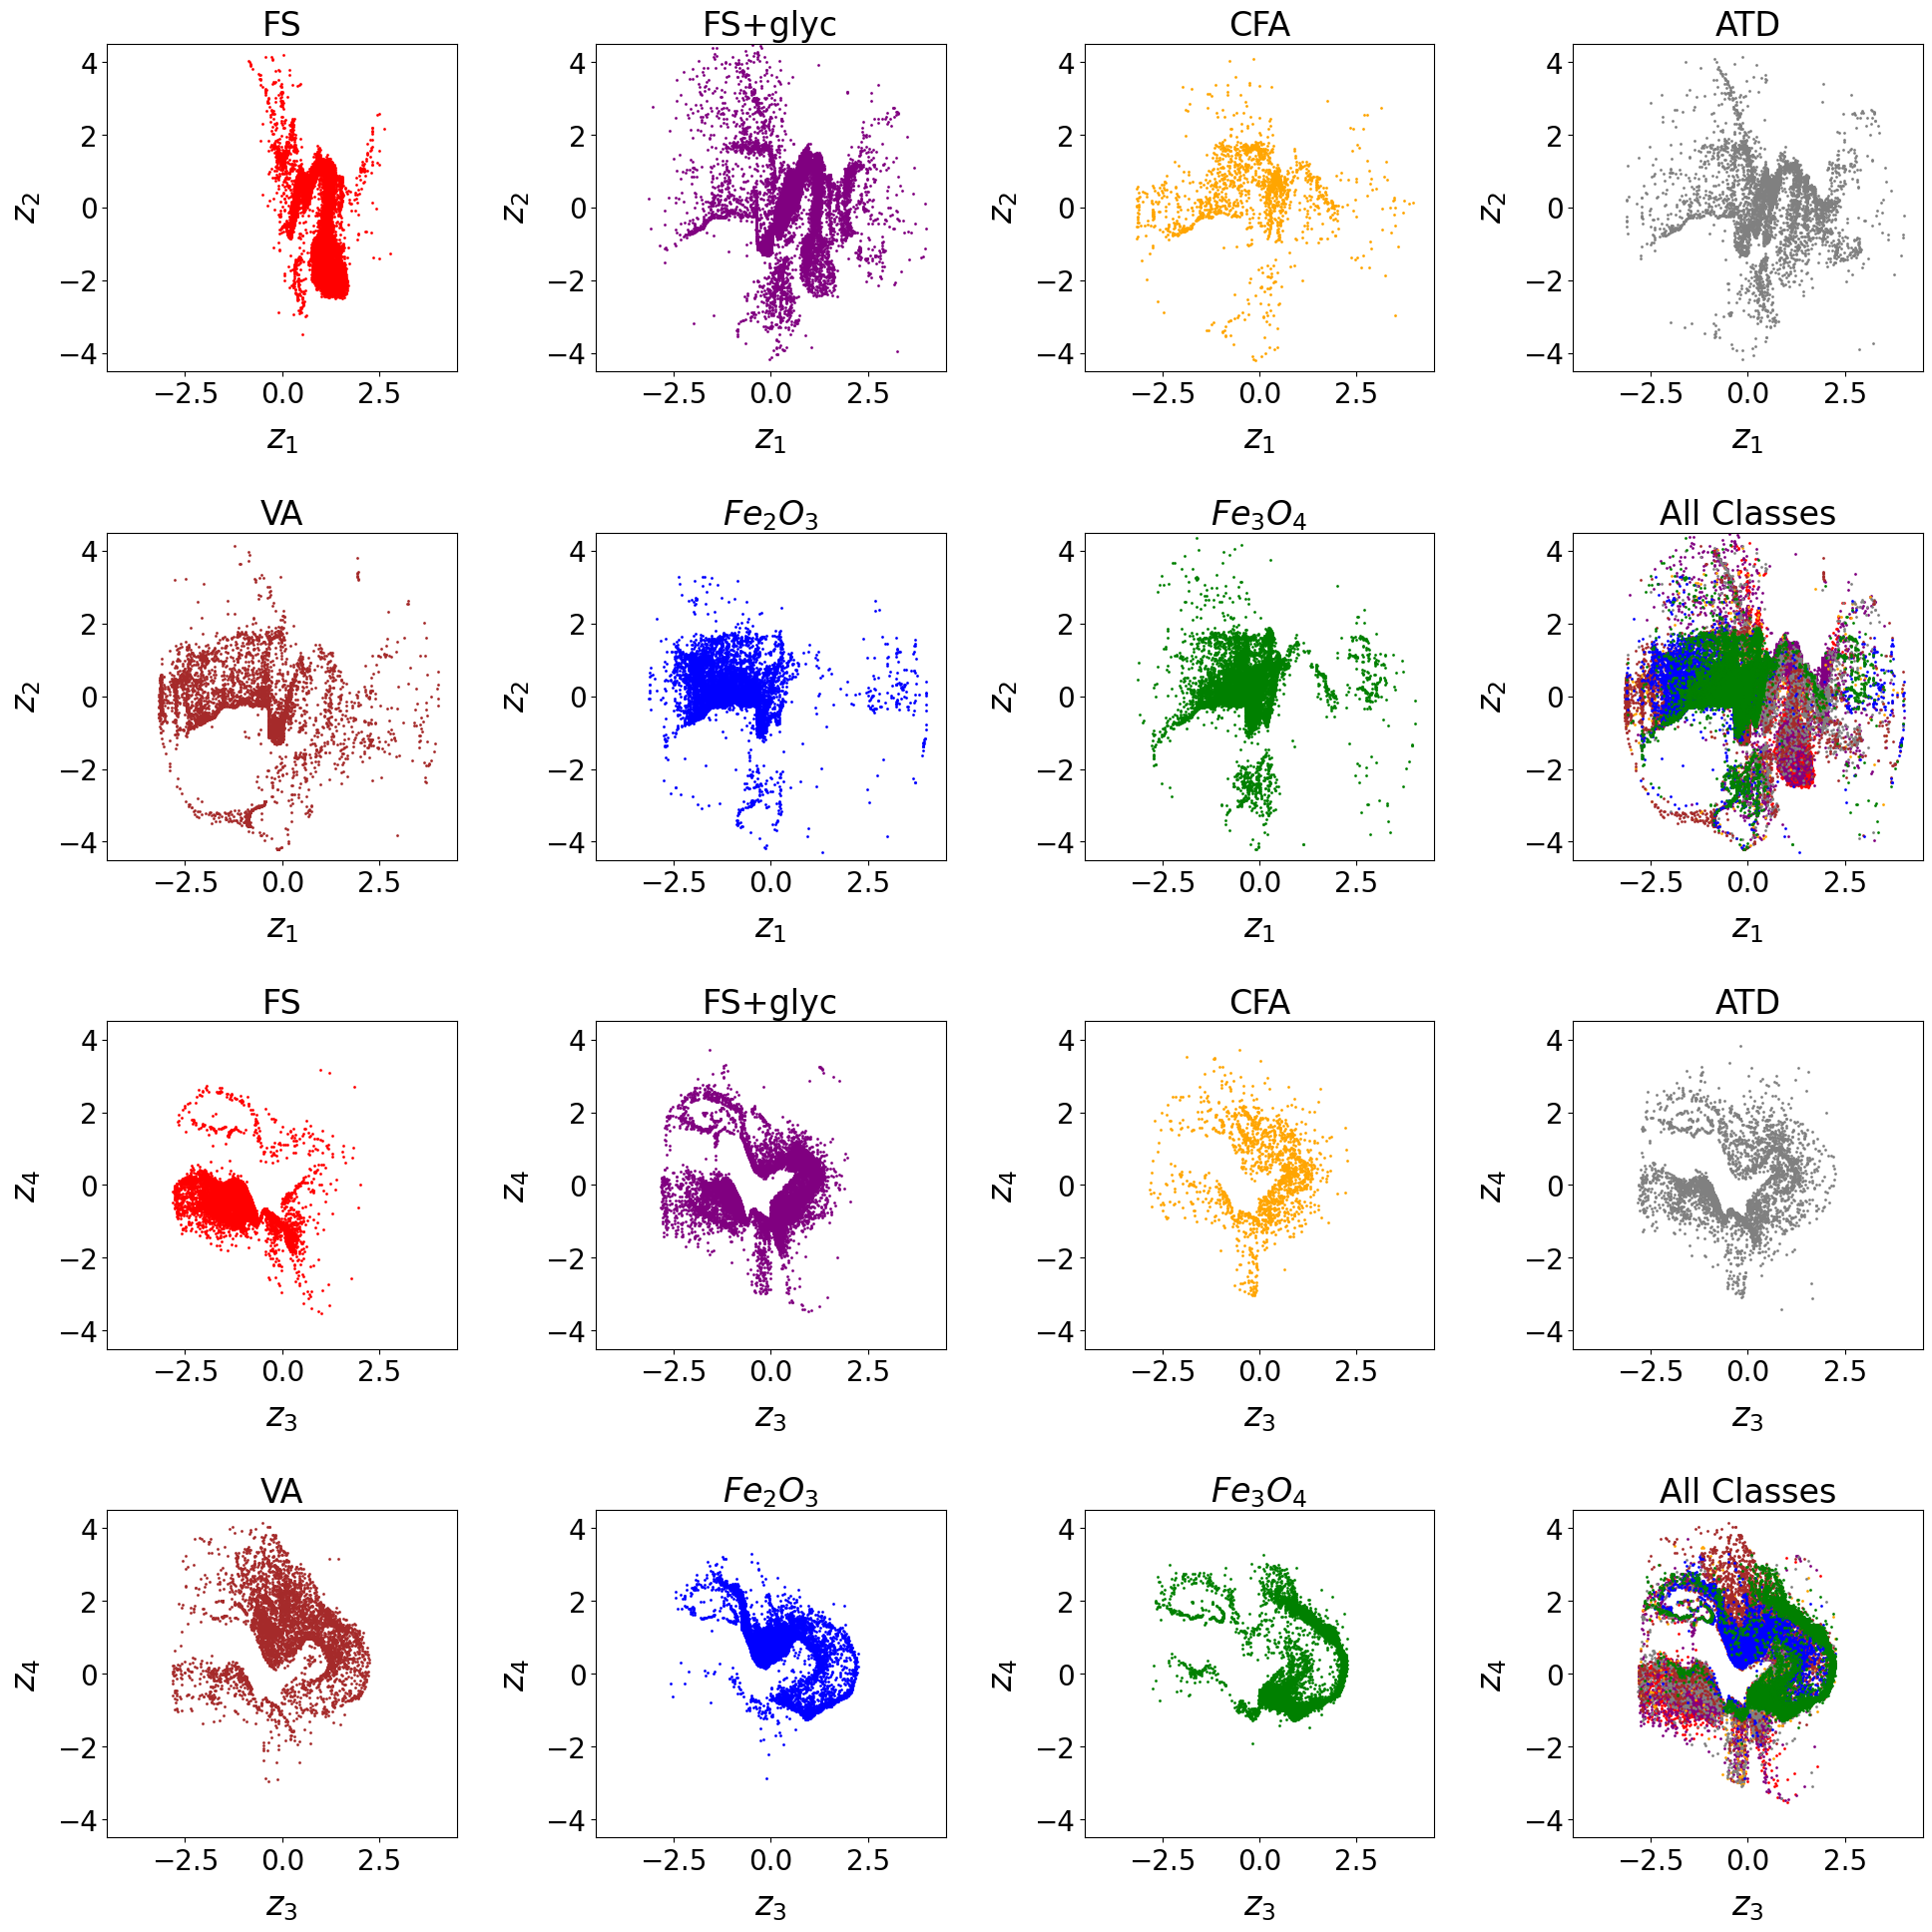

In [39]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

fs = 24

for idx_0 in range(7):
    class_indices = np.where(Y_train_filtered == idx_0)
    z_mean_class = z_mean_0[class_indices]

    ax = axs[idx_0 // 4, idx_0 % 4]
    ax.scatter(z_mean_class[:, 0], z_mean_class[:, 1], s=1, color=cmap1(idx_0), label=target_names[idx_0])
    ax.set_xlabel("$z_1$", fontsize=fs, labelpad=10)
    ax.set_ylabel("$z_2$", fontsize=fs, labelpad=10)
    #ax.legend(fontsize=11, loc='upper left')
    ax.set_title(target_names[idx_0], fontsize=fs)
    ax.tick_params(axis='both', which='major', labelsize=fs-4)
    ax.tick_params(axis='both', which='minor', labelsize=fs-6)

ax_all = axs[1, 3]
for idx_0 in range(7):
    class_indices = np.where(Y_train_filtered == idx_0)
    print(idx_0,class_indices[0].shape)
    z_mean_class = z_mean_0[class_indices]
    ax_all.scatter(z_mean_class[:, 0], z_mean_class[:, 1], s=1, color=cmap1(idx_0), label=target_names[idx_0])

ax_all.set_xlabel("$z_1$", fontsize=fs, labelpad=10)
ax_all.set_ylabel("$z_2$", fontsize=fs, labelpad=10)
#ax_all.legend(fontsize=11, loc='upper left')
ax_all.set_title("All Classes", fontsize=fs)
ax_all.tick_params(axis='both', which='major', labelsize=fs-4)
ax_all.tick_params(axis='both', which='minor', labelsize=fs-6)

for idx_1 in range(7):
    class_indices = np.where(Y_train_filtered == idx_1)
    z_mean_class = z_mean_1[class_indices]

    ax = axs[idx_1 // 4+2, idx_1 % 4]
    ax.scatter(z_mean_class[:, 0], z_mean_class[:, 1], s=1, color=cmap1(idx_1), label=target_names[idx_1])
    ax.set_xlabel("$z_3$", fontsize=fs, labelpad=10)
    ax.set_ylabel("$z_4$", fontsize=fs, labelpad=10)
    #ax.legend(fontsize=11, loc='upper left')
    ax.set_title(target_names[idx_1], fontsize=fs)
    ax.tick_params(axis='both', which='major', labelsize=fs-4)
    ax.tick_params(axis='both', which='minor', labelsize=fs-6)
    ax.grid(False)

# For the combined plot
ax_all = axs[3, 3]
for idx_1 in range(7):
    class_indices = np.where(Y_train_filtered == idx_1)
    z_mean_class = z_mean_1[class_indices]
    ax_all.scatter(z_mean_class[:, 0], z_mean_class[:, 1], s=1, color=cmap1(idx_1), label=target_names[idx_1])

ax_all.set_xlabel("$z_3$", fontsize=fs, labelpad=10)
ax_all.set_ylabel("$z_4$", fontsize=fs, labelpad=10)
#ax_all.legend(fontsize=11, loc='upper left')
ax_all.tick_params(axis='both', which='major', labelsize=fs-4)
ax_all.tick_params(axis='both', which='minor', labelsize=fs-6)
ax_all.set_title("All Classes", fontsize=fs)
ax.grid(False)

for ax in axs.flat:
    ax.set_xlim(-4.5, 4.5)
    ax.set_ylim(-4.5, 4.5)

plt.tight_layout(pad=3.0)
filename = 'LatentSpacebyClass_2DVAE.png'
plt.savefig(filename, dpi=300)
plt.show()


## Calculate cosine similarity metric

In [40]:
z_all = np.hstack((z_mean_0,z_mean_1))
zval_all = np.hstack((zval_mean_0,zval_mean_1))
ztest_all = np.hstack((ztest_mean_0,ztest_mean_1))
print(z_all.shape)

(85832, 4)


In [41]:
from sklearn.metrics.pairwise import cosine_similarity

In [42]:
def calculate_cos_sim(embeddings,class_labels):
  n_classes = len(np.unique(class_labels))

  class_cos_sims = np.zeros((n_classes,n_classes))
  for i in range(0,n_classes):
      for j in range(0,n_classes):
          classA_indices = np.where(class_labels == i)
          classB_indices = np.where(class_labels == j)
          pc_classA = embeddings[classA_indices[0],:]
          pc_classB = embeddings[classB_indices[0],:]
          pairwise_similarities = cosine_similarity(pc_classA,pc_classB)
          class_cos_sims[i,j] = np.mean(pairwise_similarities)
  return class_cos_sims

In [43]:
cos_sims_Ch0 = calculate_cos_sim(z_mean_0,Y_train)
cos_sims_Ch1 = calculate_cos_sim(z_mean_1,Y_train)

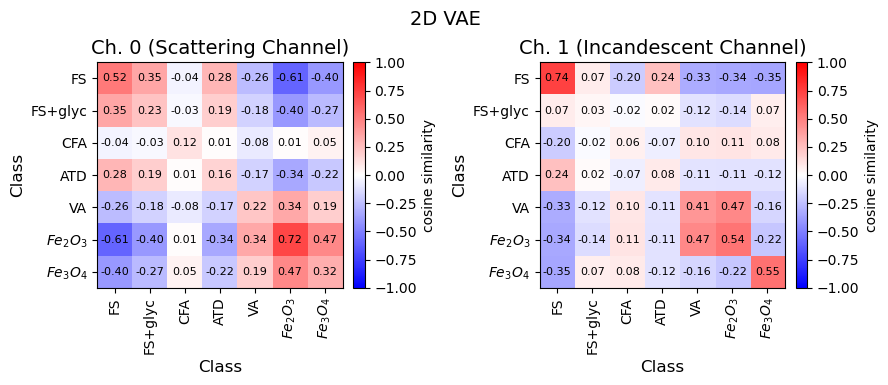

In [44]:
fig, axs = plt.subplots(1,2,figsize=(9, 4))
cos_sims = [cos_sims_Ch0,cos_sims_Ch1]
names = ["Ch. 0 (Scattering Channel)","Ch. 1 (Incandescent Channel)"]

fig.suptitle("2D VAE", fontsize=14,y=0.95)
for k in range(0,2):
    ax = axs[k]
    im = ax.imshow(cos_sims[k], aspect='auto', origin='upper',vmin=-1,vmax=1,cmap="bwr")
    ax.set_title(names[k], fontsize=14)
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('Class', fontsize=12)

    ax.set_xticks(range(len(target_names)))
    ax.set_xticklabels(target_names, rotation=90)
    ax.set_yticks(range(len(target_names)))
    ax.set_yticklabels(target_names)
    # Colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label("cosine similarity")

    for i in range(cos_sims[k].shape[0]):
        for j in range(cos_sims[k].shape[0]):
            val = cos_sims[k][i, j]
            text = "{:.2f}".format(val)
            ax.text(j, i, text, ha='center', va='center', fontsize=8)
plt.tight_layout()
plt.savefig("CosineSimilarity_2DVAE.png",dpi=300)

## Random Forest Analysis

In [45]:
# get rid of outliers
color_channel_ratio[color_channel_ratio>2] = 1
color_channel_ratio_val[color_channel_ratio_val>2] = 1
color_channel_ratio_test[color_channel_ratio_test>2] = 1
count = np.sum(color_channel_ratio > 2)
count

0

In [46]:
z_all = np.hstack((z_mean_0,z_mean_1))
z_all = np.hstack((z_all,color_channel_ratio.reshape(-1, 1),channel_max_X_train[:,0:2]))

zval_all = np.hstack((zval_mean_0,zval_mean_1))
zval_all = np.hstack((zval_all,color_channel_ratio_val.reshape(-1, 1),channel_max_X_val[:,0:2]))

ztest_all = np.hstack((ztest_mean_0,ztest_mean_1))
ztest_all = np.hstack((ztest_all,color_channel_ratio_test.reshape(-1, 1),channel_max_X_test[:,0:2]))



In [47]:
from sklearn.preprocessing import StandardScaler, normalize

In [48]:
scaler = StandardScaler()
x_all = scaler.fit_transform(z_all)
xval_all = scaler.transform(zval_all)
xtest_all = scaler.transform(ztest_all)

In [49]:
pd.DataFrame(x_all).describe()

0             1             2             3             4  \
count  8.583200e+04  8.583200e+04  8.583200e+04  8.583200e+04  8.583200e+04   
mean  -7.417354e-17 -1.324527e-17  3.708677e-17  3.973582e-17  1.258301e-14   
std    1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min   -2.989726e+00 -4.569985e+00 -2.776818e+00 -3.767490e+00 -4.556394e+00   
25%   -7.159276e-01 -4.209410e-01 -8.224319e-01 -8.113208e-01 -8.821375e-01   
50%    5.356121e-03 -8.555408e-02  1.751742e-02 -2.085450e-01 -2.179800e-02   
75%    8.405071e-01  6.559506e-01  7.201163e-01  6.625833e-01  7.918858e-01   
max    3.790293e+00  4.828165e+00  2.207781e+00  4.437779e+00  7.166129e+00   

                  5             6  
count  8.583200e+04  8.583200e+04  
mean  -2.435541e-14  1.650361e-15  
std    1.000006e+00  1.000006e+00  
min   -1.629941e+00 -7.678647e-01  
25%   -1.272180e+00 -6.957786e-01  
50%    7.039501e-01 -3.768585e-01  
75%    7.236437e-01  3.023881e-01  
max    1.074370e+00  3.988303e+00

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

rf = RandomForestClassifier()
rf.fit(x_all, Y_train)

RandomForestClassifier()

In [51]:
y_output = rf.predict(xval_all)

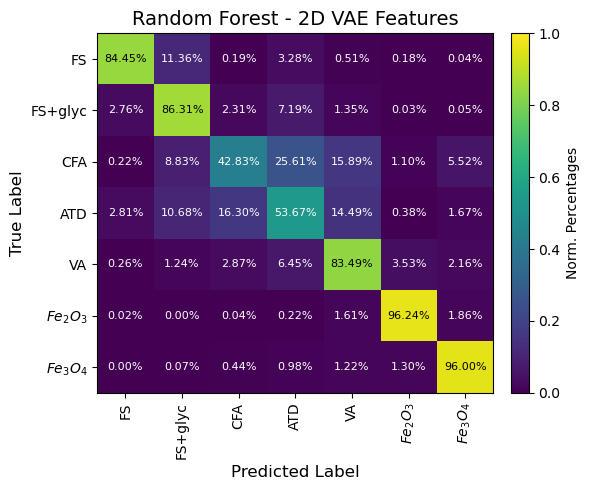

In [58]:
fig, ax = plt.subplots(figsize=(6, 5))

correlation_arr = confusion_matrix(y_output, Y_val, normalize='true')
fs = 14
im = ax.imshow(correlation_arr, aspect='auto', origin='upper',vmin=0,vmax=1,cmap="viridis")
ax.set_title("Random Forest - 2D VAE Features", fontsize=fs)
ax.set_xlabel('Predicted Label', fontsize=fs-2)
ax.set_ylabel('True Label', fontsize=fs-2)

ax.set_xticks(range(len(target_names)))
ax.set_xticklabels(target_names, rotation=90)
ax.set_yticks(range(len(target_names)))
ax.set_yticklabels(target_names)
# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=fs-4)
cbar.set_label("Norm. Percentages")

for i in range(correlation_arr.shape[0]):
    for j in range(correlation_arr.shape[0]):
        val = correlation_arr[i, j]
        text = "{:.2%}".format(val)
        if val>0.75:
          ax.text(j, i, text, ha='center', va='center', fontsize=fs-6,color='black')
        else:
          ax.text(j, i, text, ha='center', va='center', fontsize=fs-6,color='white')
plt.tight_layout()
plt.savefig('confusion_matrix_high_res.png', dpi=300)

## HDSBCAN analysis

In [133]:
from sklearn.preprocessing import StandardScaler, normalize

from sklearn.cluster import HDBSCAN

In [168]:
hdb = HDBSCAN(min_cluster_size=50)
hdb.fit(x_all)

HDBSCAN(min_cluster_size=50)

In [170]:
labels = hdb.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters)
print("Estimated number of noise points: %d" % n_noise)
for i in range(n_clusters):
    print(i,labels[labels==i].shape[0])

Estimated number of clusters: 15
Estimated number of noise points: 25664
0 141
1 313
2 223
3 135
4 59
5 78
6 277
7 67
8 104
9 102
10 71
11 185
12 28665
13 12540
14 17208


In [171]:
def cluster_class_table(y_true, cl):
    df = pd.DataFrame({'class': y_true, 'cluster': cl})
    # Count table
    counts = pd.crosstab(df['class'], df['cluster'])        # rows=class, cols=cluster
    # Normalize by rows (class-wise percentages)
    row_norm = counts.div(counts.sum(axis=1).replace(0, np.nan), axis=0)
    # Normalize by columns (cluster-wise percentages)
    col_norm = counts.div(counts.sum(axis=0).replace(0, np.nan), axis=1)
    return counts, row_norm, col_norm
def plot_heatmap(mat, title, fmt='{:.2f}', annotate=True, class_names=None,figname="Heatmap.png"):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(mat.values, aspect='auto', origin='upper')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Cluster label', fontsize=12)
    ax.set_ylabel('Class', fontsize=12)

    # x-axis: cluster labels
    ax.set_xticks(range(mat.shape[1]))
    ax.set_xticklabels([str(c) for c in mat.columns], rotation=90)

    # y-axis: class names if provided, otherwise use mat.index
    if class_names is not None:
        ax.set_yticks(range(len(class_names)))
        ax.set_yticklabels(class_names)
    else:
        ax.set_yticks(range(mat.shape[0]))
        ax.set_yticklabels([str(r) for r in mat.index])

    # Colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    # Annotate cells
    if annotate:
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                val = mat.iat[i, j]
                text = fmt.format(val) if fmt is not None else str(val)
                ax.text(j, i, text, ha='center', va='center', fontsize=8)

    plt.tight_layout()
    plt.savefig(figname,dpi=300)

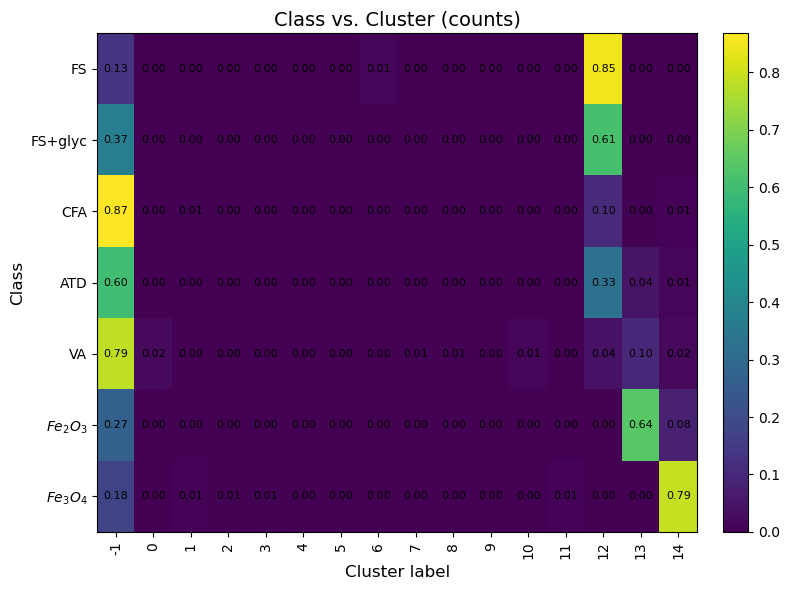

In [172]:
counts, row_norm, col_norm = cluster_class_table(Y_train, hdb.labels_)

# Raw counts (good for volume)
plot_heatmap(row_norm, 'Class vs. Cluster (counts)', fmt='{:.2f}',class_names=target_names,figname="HDBSCANClustervsClass.png")

In [173]:
import matplotlib as mpl
import matplotlib.pylab as plt

cmap = plt.cm.tab20  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (0,0,0,1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, n_clusters-1, n_clusters)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

/var/folders/n1/j9r40q610fjg5jmq47vnbz2m0000gn/T/ipykernel_1676/286168063.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(target_names)


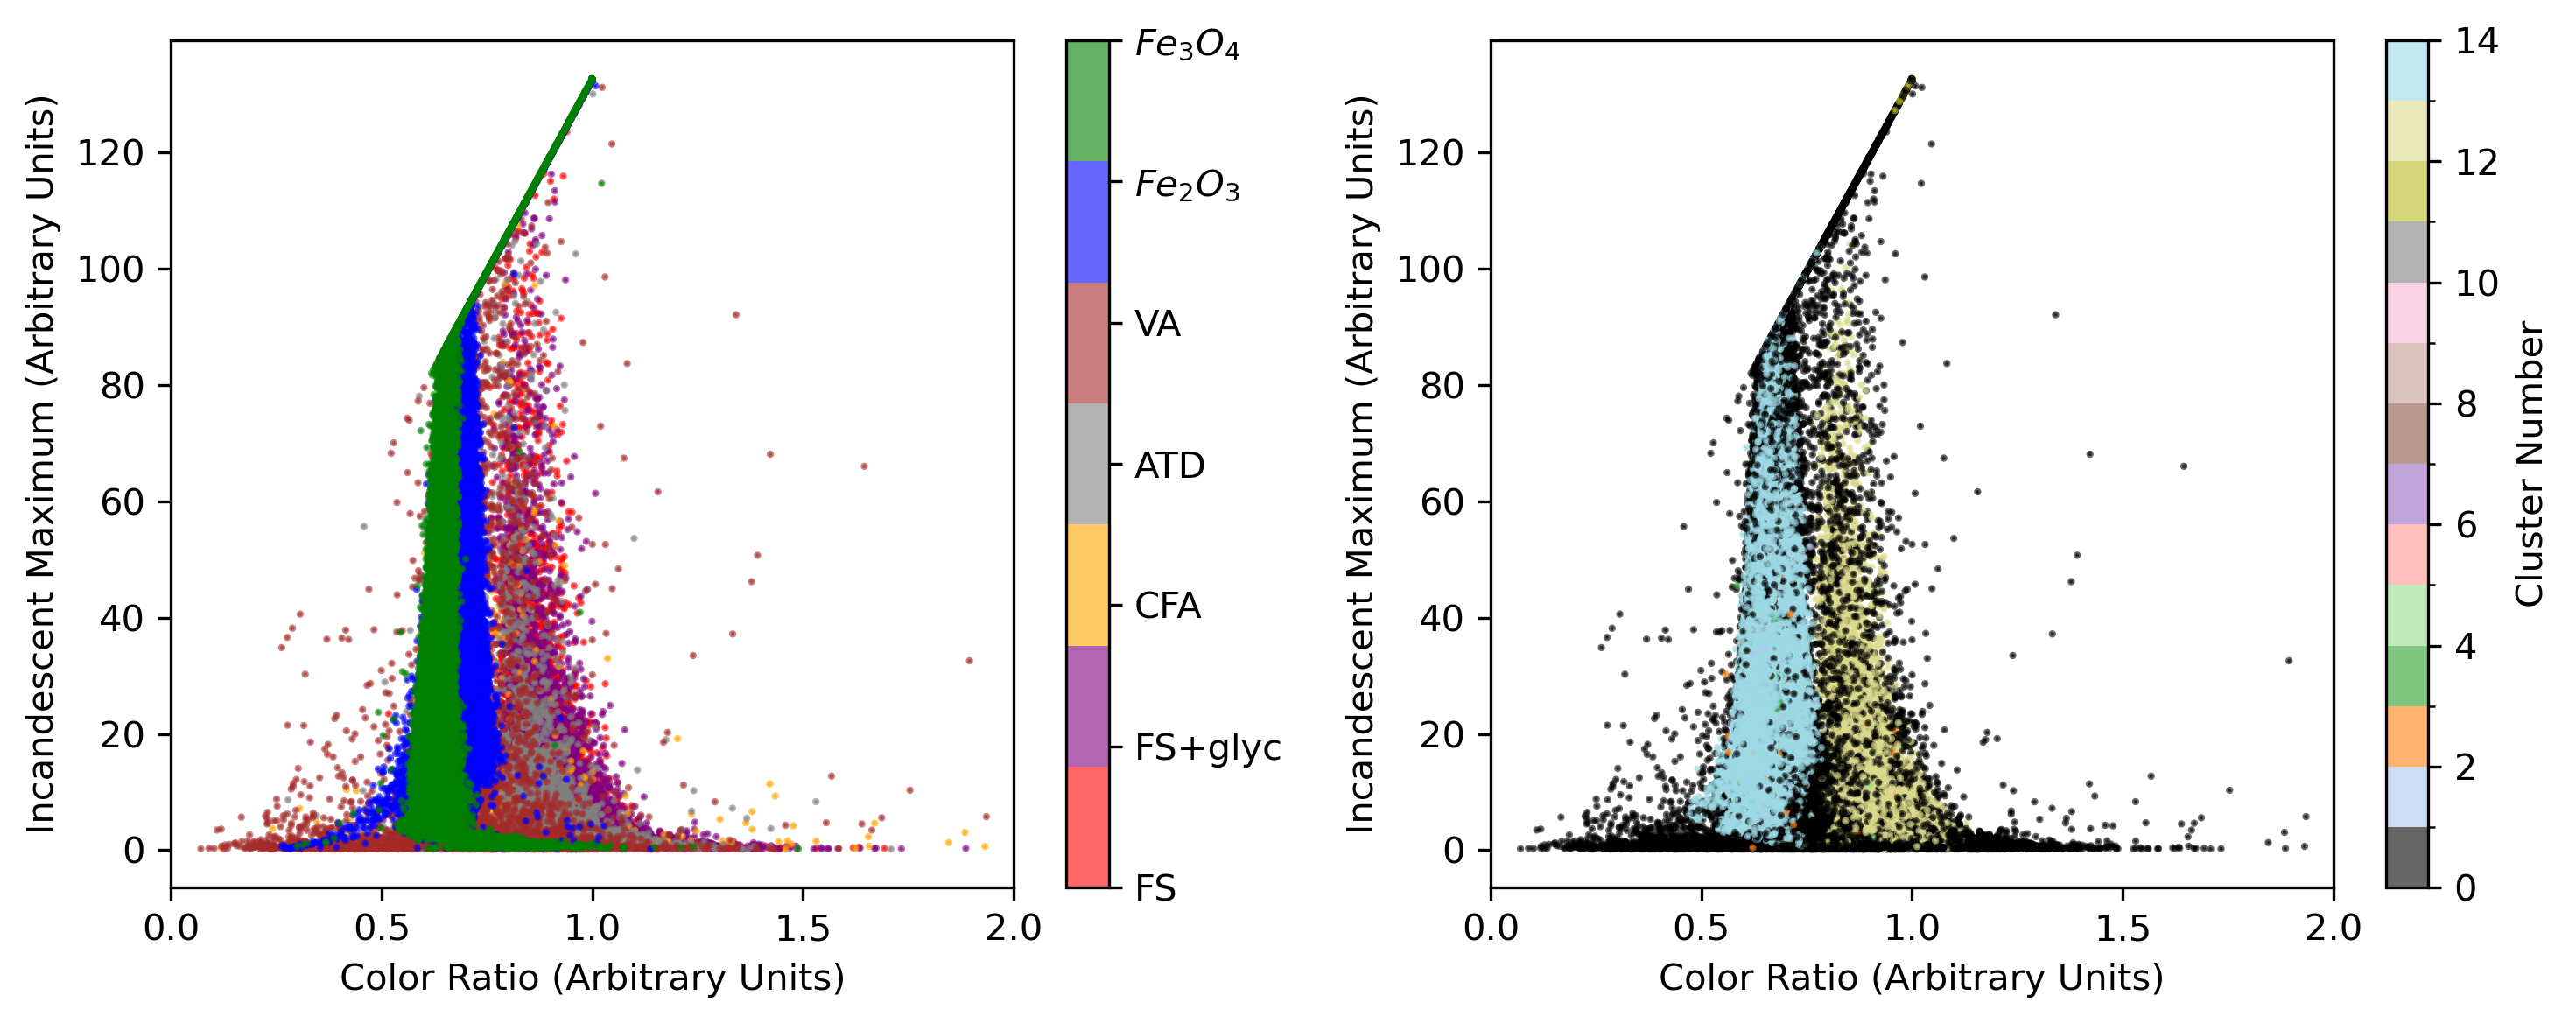

In [174]:
fig, axes = plt.subplots(1,2, figsize=(10, 4), dpi=300)
fig.subplots_adjust(hspace=0.3, wspace=0.3)

axes = axes.flatten()

sc0 = axes[0].scatter(
    color_channel_ratio,
    channel_max_X_train[:,1],
    c=Y_train_filtered,
    s=1,
    cmap=cmap1,
    alpha=0.6
)
axes[0].set_xlim(0, 2)
axes[0].set_xlabel("Color Ratio (Arbitrary Units)")
axes[0].set_ylabel("Incandescent Maximum (Arbitrary Units)")
cbar = fig.colorbar(sc0, ax=axes[0])
cbar.set_ticklabels(target_names)

sc1 = axes[1].scatter(
    color_channel_ratio,
    channel_max_X_train[:,1],
    c=hdb.labels_,
    s=1,
    cmap=cmap,
    norm=norm,
    alpha=0.6
)
axes[1].set_xlim(0, 2)
axes[1].set_xlabel("Color Ratio (Arbitrary Units)")
axes[1].set_ylabel("Incandescent Maximum (Arbitrary Units)")
cbar2 = fig.colorbar(sc1, ax=axes[1],label="Cluster Number")

plt.tight_layout()
plt.savefig("HDBscanSP2.png", dpi=300)
plt.show()